# Descriptif général du projet

## Contexte
TechNova Partners, une ESN spécialisée en transformation digitale et SaaS, fait face à **un taux de démission élevé**.  
Le département RH mandate un **Consultant Data Scientist** pour **identifier les causes de ces départs** à l’aide des données internes.

## Données fournies
Trois fichiers transmis :
1. **Données SIRH** : fonction, âge, ancienneté, salaire, infos sociodémographiques.
2. **Évaluations annuelles** : notes de performance et satisfaction.
3. **Sondage bien-être** : réponses au questionnaire + indicateur de démission (label).

## Objectif global
- **Analyser les différences** entre employés partis et restants.
- **Construire un modèle de classification** pour **prédire les départs** d’employés.
- **Interpréter le modèle** pour **extraire les causes probables** des départs.

## Livrables attendus
- Fichier `pyproject.toml` (Python + dépendances).
- Un ou plusieurs **Jupyter Notebooks** / scripts `.py` :
  - Nettoyage
  - Analyse exploratoire
  - Modélisation
- Support de présentation 

# Import des packages et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Active l'affichage des graphiques directement dans le notebook
%matplotlib inline

# Affiche toutes les colonnes des DataFrames sans les tronquer
pd.set_option('display.max_columns', None)

# Applique un style visuel clair et lisible aux graphiques Seaborn
sns.set(style="whitegrid")


In [2]:
df_sirh = pd.read_csv("data/extrait_sirh.csv")
df_sondage = pd.read_csv("data/extrait_sondage.csv")
df_evaluation = pd.read_csv("data/extrait_eval.csv")

# Nettoyage des données brutes et identification de la cible

## Objectifs

Cette étape vise à garantir la qualité, la cohérence et la compatibilité des trois fichiers sources (SIRH, évaluations de performance, sondage) avant la fusion et l'analyse exploratoire.

Elle constitue une phase préalable pour :
- **Assurer la fiabilité des données** : vérification des types, détection et traitement des valeurs manquantes ou aberrantes ;
- **Faciliter la fusion des jeux de données** : identification des clés communes, harmonisation des structures, nettoyage des doublons ;
- **Préparer les données aux futures analyses** entre les employés ayant quitté l’entreprise et ceux qui y sont restés.

Le résultat attendu est un ensemble de jeux de données intermédiaires, propres et homogènes, prêts à être combinés dans un DataFrame central exploitable pour la suite du projet.

## Nettoyage du fichier SIRH

In [3]:
df_sirh.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


In [4]:
#🧹 On va supprimer les espaces inutiles s'il y a lieu
df_sirh.columns = df_sirh.columns.str.strip()

In [5]:
df_sirh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


In [6]:
df_sirh.dtypes

id_employee                        int64
age                                int64
genre                             object
revenu_mensuel                     int64
statut_marital                    object
departement                       object
poste                             object
nombre_experiences_precedentes     int64
nombre_heures_travailless          int64
annee_experience_totale            int64
annees_dans_l_entreprise           int64
annees_dans_le_poste_actuel        int64
dtype: object

In [7]:
df_sirh.describe()

,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000
mean,1024.865306,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252
std,602.024335,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137
min,1.000000,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000
25%,491.250000,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000
50%,1020.500000,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000
75%,1555.750000,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000
max,2068.000000,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000


<Axes: >

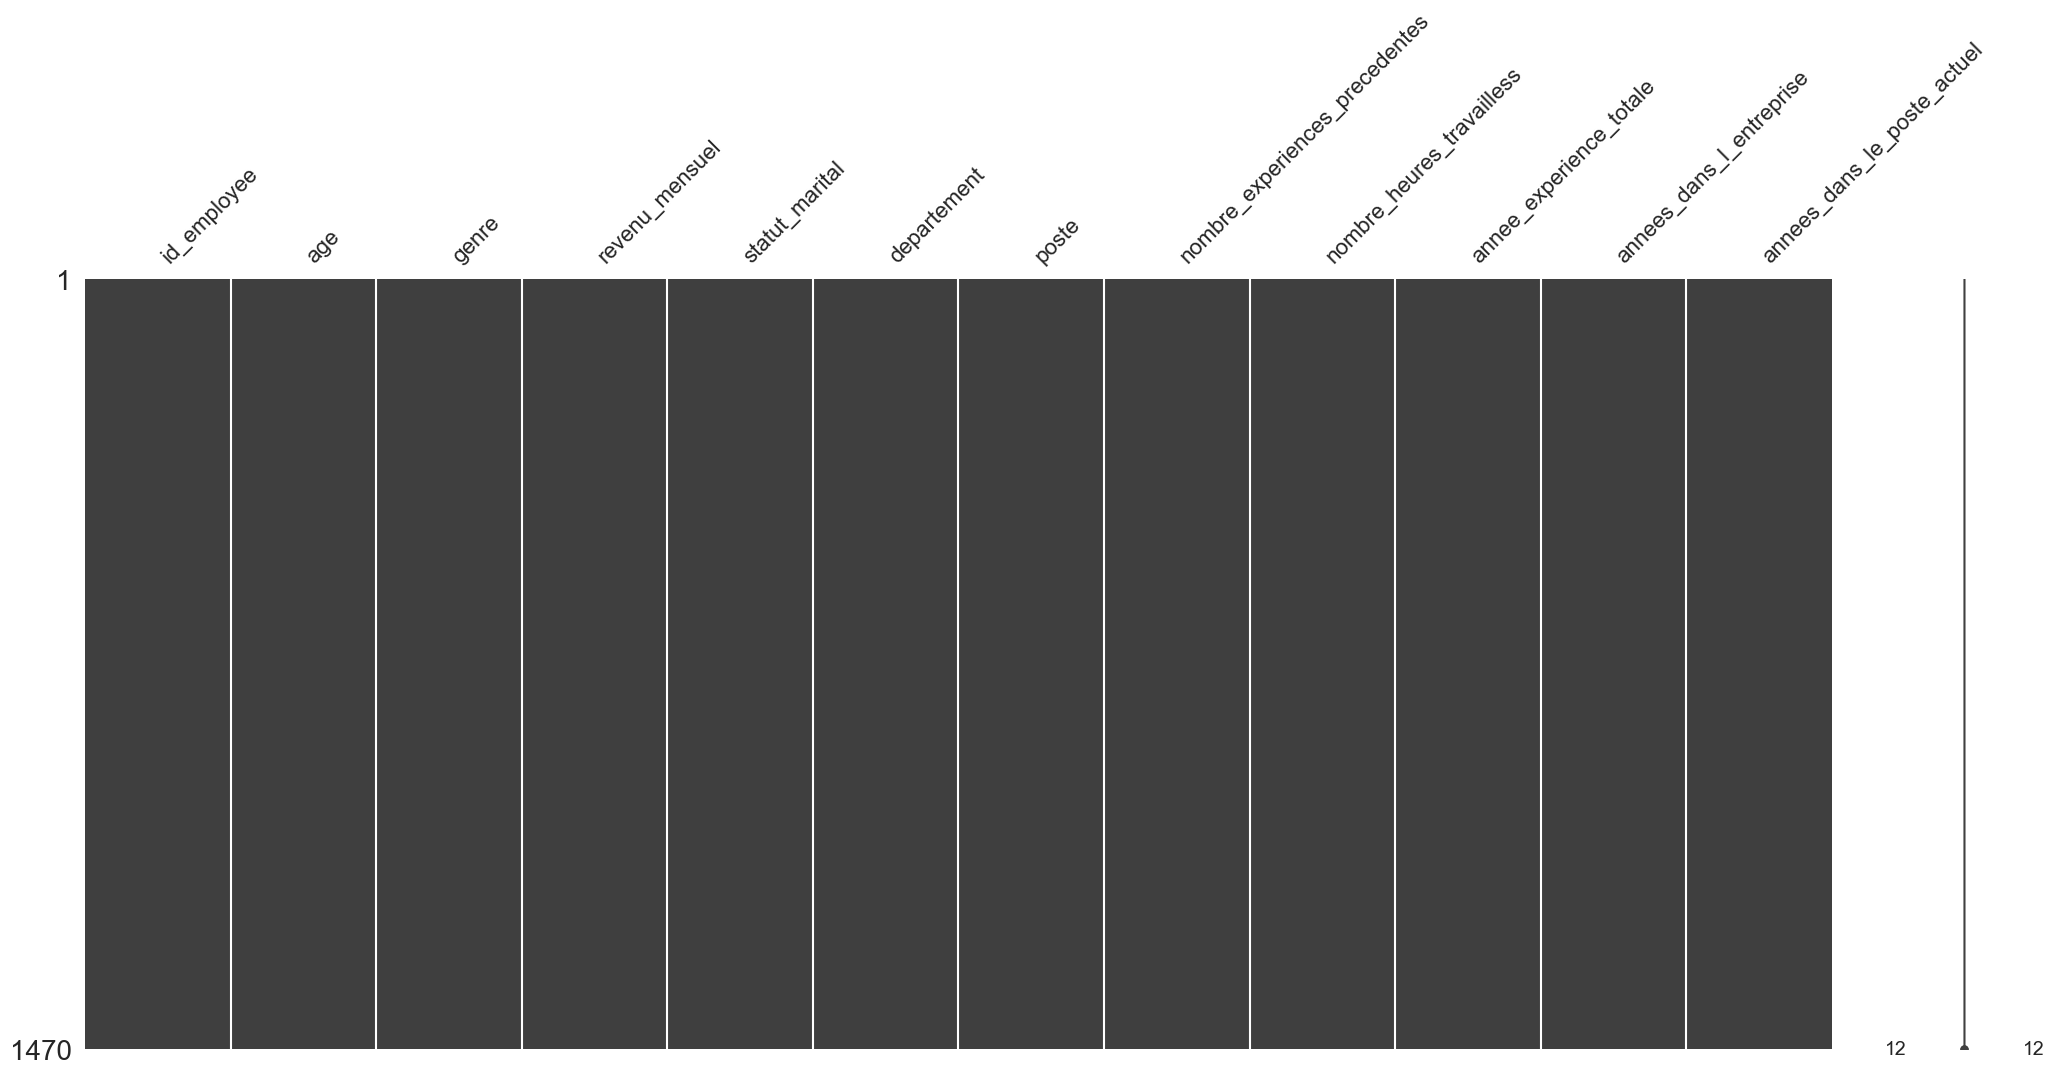

In [8]:
msno.matrix(df_sirh)

La matrice missingno n’affiche aucun pattern de valeurs manquantes, confirmant le diagnostic de df_sirh.info()

Aucun problème détecté lors de l’inspection initiale du fichier SIRH, mis à part des valeurs égales à 0 mais qui ne paraîssent pas aberrantes au premier abord et que nous examinerons lors de l'analyse monovariée.

## Nettoyage du fichier des évaluations

In [9]:
df_evaluation.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


In [10]:
# 🧹 On va supprimer les espaces inutiles s'il y a lieu
df_evaluation.columns = df_evaluation.columns.str.strip()

In [11]:
df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(7), object(3)
memory usage:

In [12]:
df_evaluation.dtypes

satisfaction_employee_environnement           int64
note_evaluation_precedente                    int64
niveau_hierarchique_poste                     int64
satisfaction_employee_nature_travail          int64
satisfaction_employee_equipe                  int64
satisfaction_employee_equilibre_pro_perso     int64
eval_number                                  object
note_evaluation_actuelle                      int64
heure_supplementaires                        object
augementation_salaire_precedente             object
dtype: object

In [13]:
df_evaluation.describe()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,2.721769,2.729932,2.063946,2.728571,2.712245,2.761224,3.153741
std,1.093082,0.711561,1.106940,1.102846,1.081209,0.706476,0.360824
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000
50%,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000
max,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000


Rien à signaler de particulier lors de l’inspection initiale du fichier des évaluations. On voit que id_employee est absente mais, apparemment on retrouve l'ID dans eval_number. Nous vérifierons cela plus tard. Le cas échéant, il faudra nettoyer le E_ devant et transformer la colonne en int64.

## Nettoyage du fichier du sondage

In [14]:
df_sondage.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [15]:
# 🧹 On va supprimer les espaces inutiles s'il y a lieu
df_sondage.columns = df_sondage.columns.str.strip()

In [16]:
df_sondage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

In [17]:
df_sondage.dtypes

a_quitte_l_entreprise                  object
nombre_participation_pee                int64
nb_formations_suivies                   int64
nombre_employee_sous_responsabilite     int64
code_sondage                            int64
distance_domicile_travail               int64
niveau_education                        int64
domaine_etude                          object
ayant_enfants                          object
frequence_deplacement                  object
annees_depuis_la_derniere_promotion     int64
annes_sous_responsable_actuel           int64
dtype: object

In [18]:
df_sondage.describe()

,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.793878,2.799320,1.0,1024.865306,9.192517,2.912925,2.187755,4.123129
std,0.852077,1.289271,0.0,602.024335,8.106864,1.024165,3.222430,3.568136
min,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,1.0,491.250000,2.000000,2.000000,0.000000,2.000000
50%,1.000000,3.000000,1.0,1020.500000,7.000000,3.000000,1.000000,3.000000
75%,1.000000,3.000000,1.0,1555.750000,14.000000,4.000000,3.000000,7.000000
max,3.000000,6.000000,1.0,2068.000000,29.000000,5.000000,15.000000,17.000000


L'inspection ne révèle pas de problème particulier. L'ID employé est ici le code_sondage.

## Conclusion de la phase de nettoyage des 3 fichiers

🧹L’analyse exploratoire a confirmé qu’aucune valeur manquante n’était présente dans les trois fichiers d’origine. 

## Identification et validation de la cible

La variable cible (indiquant la démission) est présente dans le fichier de sondage "a_quitte_l_entreprise". Elle servira à distinguer les deux groupes d’employés dans l’analyse et à entraîner le modèle de classification.

In [19]:
# Vérification du format
df_sondage['a_quitte_l_entreprise'].value_counts()

a_quitte_l_entreprise
Non    1233
Oui     237
Name: count, dtype: int64

On peut tout de suite noter que la classification est désiquilibrée

## Codage de la cible en valeurs binaires

In [20]:
# 🧹 Codage de la cible en binaire df = df.replace({'y': 1, 'n': -1, '?': 0})
df_sondage['a_quitte_l_entreprise'] = df_sondage['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})

# Fusion des fichiers

## Objectif
Créer un DataFrame central unique à partir des trois fichiers de données (SIRH, évaluations, sondage), en rassemblant toutes les informations disponibles pour chaque employé.


## Vérification des clés de jointure
- Identification des colonnes communes permettant l’appariement des fichiers (identifiants uniques).

**Colonnes communes idéntifiées :**
- df_sirh : id_employee
- df_evaluation : eval_number --> Nettoyer avant le "E_" en trop devant chaque ID
- df_sondage : code sondage

**Actions préalables**
- Vérification que les clés sont bien uniques
- Contrôle de l’unicité de ces identifiants dans chaque fichier.

In [21]:
# Verification que les clés sont uniques
df_sirh['id_employee'].nunique()

1470

In [22]:
df_sondage['code_sondage'].nunique()

1470

In [23]:
df_evaluation['eval_number'].nunique()

1470

Les clés sont bien uniques

In [24]:
# Vérification de l'unicité des ID SIRH et sondage avec la méthode equals (oui si True)
df_sirh['id_employee'].equals(df_sondage['code_sondage'])

True

In [25]:
# 🧹 Nettoyage des caractères inutiles dans eval_number de df_evaluation
df_evaluation['eval_number'] = df_evaluation['eval_number'].str.replace("E_", "", regex=False)

In [26]:
# 🧹 Conversion de la colonne en integer
df_evaluation["eval_number"] = df_evaluation["eval_number"].astype('int64')

In [27]:
df_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   int64 
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augementation_salaire_precedente           1470 non-null   object
dtypes: int64(8), object(2)
memory usage:

In [28]:
# Vérification de l'unicité des ID SIRH et evaluation avec la méthode equals (oui si True)
df_sirh['id_employee'].equals(df_evaluation['eval_number'])

True

On a maintenant 3 fichiers avec unicité des identifiants

### Choix des types de jointure

Nous avons d’abord vérifié que les identifiants des employés sont uniques dans les trois DataFrames à l’aide de .nunique(), ce qui permet de les considérer comme des clés primaires.
Nous avons également comparé les colonnes d’identifiants sur les 3 sources, ce qui indique que les identifiants sont strictement identiques et dans le même ordre.
Dans ce contexte, une jointure inner est adaptée : elle permet de conserver uniquement les employés présents dans l’ensemble des fichiers, ce qui garantit la cohérence des données fusionnées.

### Fusion des 3 dataframes en un

In [29]:
# Jointure de SIRH et sondage
df_intermediaire = df_sirh.merge(df_sondage, how='inner', left_on='id_employee', right_on='code_sondage')

In [30]:
# Suppression de la colonne code_sondage
df_intermediaire.drop(columns='code_sondage', inplace=True)

In [31]:
# Puis jointure avec le fichier evaluation pour obtenir le dataframe final
df_employes = df_intermediaire.merge(df_evaluation, how='inner', left_on='id_employee', right_on='eval_number')

In [32]:
# Suppression de la colonne eval_number
df_employes.drop(columns='eval_number', inplace=True)

In [33]:
# Vérification :
df_employes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_travailless                  1470 non-null   int64 
 9   annee_experience_totale                    1470 non-null   int64 
 10  annees_dans_l_entreprise            

In [34]:
df_employes.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,1,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,2,3,2,4,1,1,3,Oui,11 %
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,0,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7,3,2,2,2,4,3,4,Non,23 %
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,1,0,3,1,2,2,Autre,Y,Occasionnel,0,0,4,2,1,3,2,3,3,Oui,15 %
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,0,0,3,1,3,4,Infra & Cloud,Y,Frequent,3,0,4,3,1,3,3,3,3,Oui,11 %
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,0,1,3,1,2,1,Transformation Digitale,Y,Occasionnel,2,2,1,3,1,2,4,3,3,Non,12 %


# Synthèse des transformations de nettoyage et préparation des données avant analyse exploratoire

Dans cette phase exploratoire et de fusion, les opérations suivantes ont été réalisées sur les jeux de données importés :

##### 📂 Fichier `df_sirh`
- Suppression des espaces inutiles dans les noms de colonnes (`str.strip()`).

##### 📂 Fichier `df_evaluation`
- Suppression des espaces inutiles dans les noms de colonnes.
- Nettoyage des valeurs :
  - Retrait du préfixe `"E_"` dans la colonne `eval_number`
- Conversion des types :
  - `eval_number` converti en entier (`int64`).

##### 📂 Fichier `df_sondage`
- Suppression des espaces inutiles dans les noms de colonnes.
- Codage de la variable cible `a_quitte_l_entreprise` :
  - `Oui` remplacé par `1`
  - `Non` remplacé par `0`

##### Fichier unifié après fusions
- Suppression des colonnes `code_sondage` et `eval_number` 

##### ✅ Vérification des valeurs manquantes
- Aucune valeur manquante détectée dans les trois fichiers (vérifié avec `df.info()` et  une fois avec `missingno.matrix()`).
- Par anticipation d’un futur déploiement, une étape d’imputation sera intégrée dans le pipeline de modélisation (stratégie : médiane).

---

⚠️ **Important**  
Ces transformations ont été réalisées dans le cadre de l’exploration et de la fusion.  
Pour assurer la reproductibilité et préparer un traitement en SQL, chaque opération pourra être réimplémentée sous forme de requête structurée. Une étape d'imputation non nécessaire ici pourra être anticipée dans le cadre de la phase de déploiement.


# Analyse exploratoire

**Objectif**

Explorer statistiquement et visuellement le DataFrame central afin d’identifier les différences notables entre les employés ayant quitté l’entreprise et ceux qui y sont restés. Cette analyse servira à formuler des hypothèses sur les facteurs potentiels de démission.

## Analyse univariée Globale

### Objectif
Comprendre la distribution de chaque variable indépendamment, qu’elle soit quantitative ou qualitative.

Pour cela, les variables ont été regroupées en catégories fonctionnelles (ex. : variables sociodémographiques, professionnelles, d’évaluation, etc.).  

### Suppression de la variable identifiant
La variable `id_employee` est un identifiant technique unique, sans signification métier ou statistique ; elle est donc exclue de l’analyse exploratoire et des étapes de modélisation.

In [35]:
df_employes.drop(columns=['id_employee'], inplace=True)

### Variables sociodémographiques
Ce groupe rassemble les variables décrivant les caractéristiques personnelles des employés, telles que leur genre, situation familiale, niveau d'études ou habitudes de déplacement.  
Ces variables permettent d'explorer d'éventuelles disparités ou corrélations entre les profils sociodémographiques et le phénomène de démission observé.

##### Age

In [36]:
df_employes['age'].describe()

count    1470.000000
mean       36.923810
std         9.135373
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: age, dtype: float64

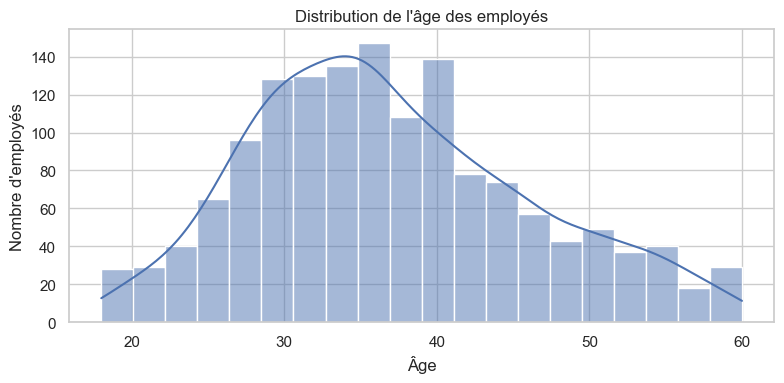

In [37]:
plt.figure(figsize=(8, 4))
sns.histplot(df_employes['age'], bins=20, kde=True)
plt.title("Distribution de l'âge des employés")
plt.xlabel("Âge")
plt.ylabel("Nombre d'employés")
plt.tight_layout()
plt.show()


La variable `age` est une variable numérique continue représentant l’âge des employés.  
Sa distribution est la suivante :
- Minimum : 18 ans
- Maximum : 60 ans
- Médiane : 36 ans
- Moyenne : 36,9 ans
- Écart-type : 9,1 ans

La répartition est relativement équilibrée, sans valeurs aberrantes évidentes.

##### Genre

In [38]:
# Genre
df_employes['genre'].value_counts(dropna=False)

genre
M    882
F    588
Name: count, dtype: int64

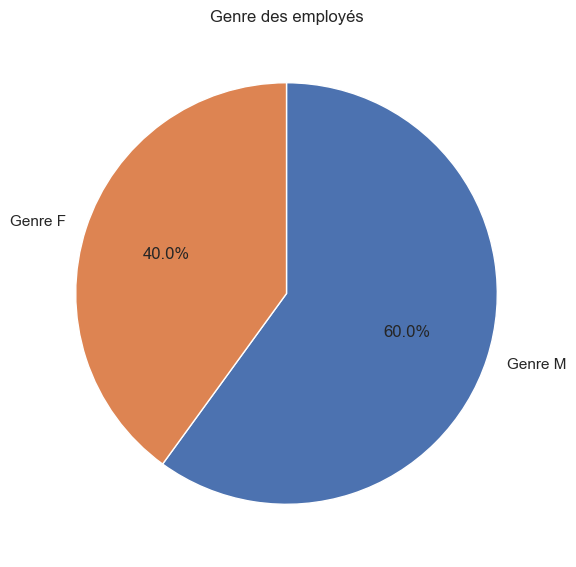

In [39]:
genre_employes = df_employes['genre'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    genre_employes,
    labels=[f"Genre {i}" for i in genre_employes.index],
    autopct='%1.1f%%',      # Ajoute les pourcentages
    startangle=90,          # Commence à 12h
    counterclock=False,     # Sens horaire
    wedgeprops={"edgecolor": "white"}  # Meilleure séparation des parts
)
plt.title("Genre des employés")
plt.tight_layout()
plt.show()

La variable `genre` est une variable catégorielle binaire indiquant le sexe des employés.

**Répartition :**
- Masculin (`M`) : 882 observations
- Féminin (`F`) : 588 observations

On va transforme cette variable en binaire (0/1) lors de la préparation des données, selon la convention suivante :
- `M` = 0
- `F` = 1

In [40]:
# Création du binaire genre
df_employes["genre_binaire"] = df_employes["genre"].map({"M":1, "F":0})

In [41]:
df_employes.drop(columns='genre', inplace=True)

##### Statut marital

In [42]:
df_employes['statut_marital'].value_counts()

statut_marital
Marié(e)       673
Célibataire    470
Divorcé(e)     327
Name: count, dtype: int64

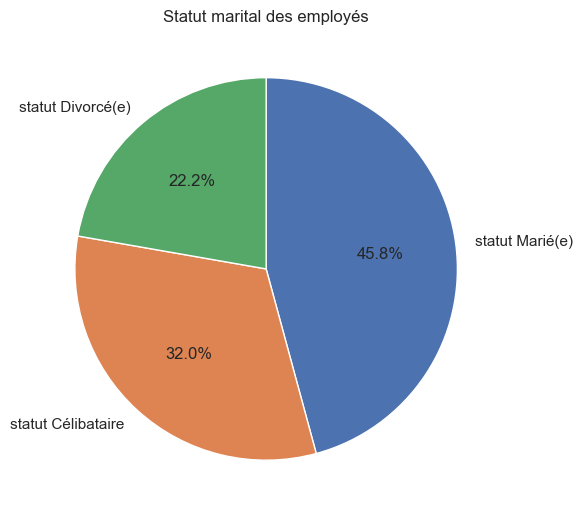

In [43]:
situation_maritale = df_employes['statut_marital'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    situation_maritale,
    labels=[f"statut {i}" for i in situation_maritale.index],
    autopct='%1.1f%%',      # Ajoute les pourcentages
    startangle=90,          # Commence à 12h
    counterclock=False,     # Sens horaire
    wedgeprops={"edgecolor": "white"}  # Meilleure séparation des parts
)
plt.title("Statut marital des employés")
plt.tight_layout()
plt.show()

La variable `statut_marital` est une variable catégorielle à trois modalités clairement définies.  
Elle est conservée telle quelle pour l’analyse univariée, et sera encodée en variables indicatrices (one-hot encoding) lors de l’étape de préparation des données en vue de la modélisation.

##### Ayant enfants

In [44]:
df_employes['ayant_enfants'].value_counts()

ayant_enfants
Y    1470
Name: count, dtype: int64

In [45]:
#🧹 Suppression de la colonne car une seule valeur
df_employes.drop(columns=['ayant_enfants'], inplace=True)

##### Domaine d'étude

In [46]:
df_employes['domaine_etude'].value_counts()

domaine_etude
Infra & Cloud              606
Transformation Digitale    464
Marketing                  159
Entrepreunariat            132
Autre                       82
Ressources Humaines         27
Name: count, dtype: int64

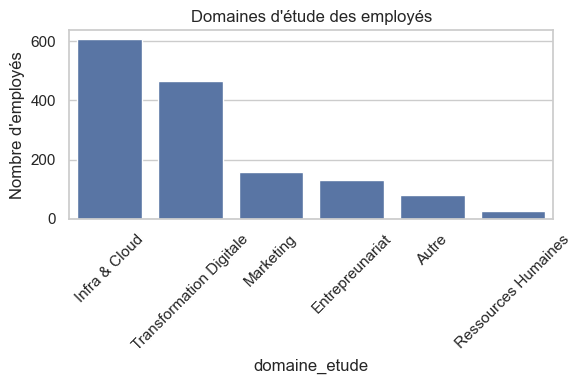

In [47]:
# Configuration de style
sns.set(style="whitegrid")

# Histogramme pour 'departement'
plt.figure(figsize=(6, 4))
sns.countplot(data=df_employes, x='domaine_etude', order=df_employes['domaine_etude'].value_counts().index)
plt.title("Domaines d'étude des employés")
plt.xlabel("domaine_etude")
plt.ylabel("Nombre d'employés")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On constate qu'on est bien dans une ESN avec des profils informatiques en majorité.

La variable `domaine_etude` contient 6 modalités distinctes non ordinales, représentant les spécialisations métier des employés.

##### Niveau d'éducation

In [48]:
df_employes['niveau_education'].value_counts()

niveau_education
3    572
4    398
2    282
1    170
5     48
Name: count, dtype: int64

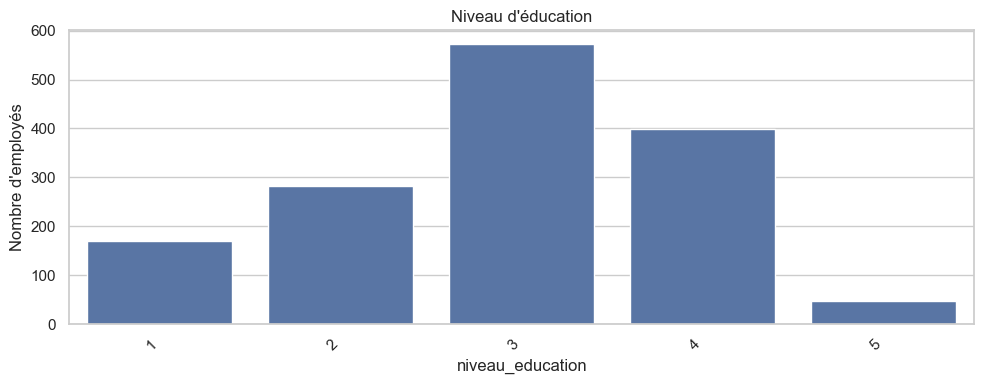

In [49]:
# Histogramme pour 'niveau_education'
plt.figure(figsize=(10, 4))
sns.countplot(
    data=df_employes,
    x='niveau_education',
    order=sorted(df_employes['niveau_education'].unique())  # trie les niveaux
)
plt.title("Niveau d'éducation")
plt.xlabel("niveau_education")
plt.ylabel("Nombre d'employés")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

On a du mal à déterminer s'il s'agit des années après le bac. En tout cas cela ne correspond pas à la nomenclature relative au niveau de diplôme en vigueur en France.

On va partir du principe que les niveaux 2 et 3 correspondraient plus à des niveaux techniciens et/ou chefs de projet et au delà des niveaux ingénieurs, étant donné que nous sommes dans une ESN.

La variable `niveau_education` contient 5 catégories ordinales, représentant le niveau d'étude des employés.

un encodage ordonné sera appliqué à l’aide du `OrdinalEncoder` de la bibliothèque `category_encoders`.

##### Fréquence de déplacement

In [50]:
df_employes['frequence_deplacement'].value_counts()

frequence_deplacement
Occasionnel    1043
Frequent        277
Aucun           150
Name: count, dtype: int64

La variable `frequence_deplacement` contient 3 catégories ordinales, représentant la fréquence des déplacements des employés.

un encodage ordonné sera appliqué à l’aide du `OrdinalEncoder` de la bibliothèque `category_encoders`.

##### Distance domicile-travail

In [51]:
df_employes['distance_domicile_travail'].describe()

count    1470.000000
mean        9.192517
std         8.106864
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: distance_domicile_travail, dtype: float64

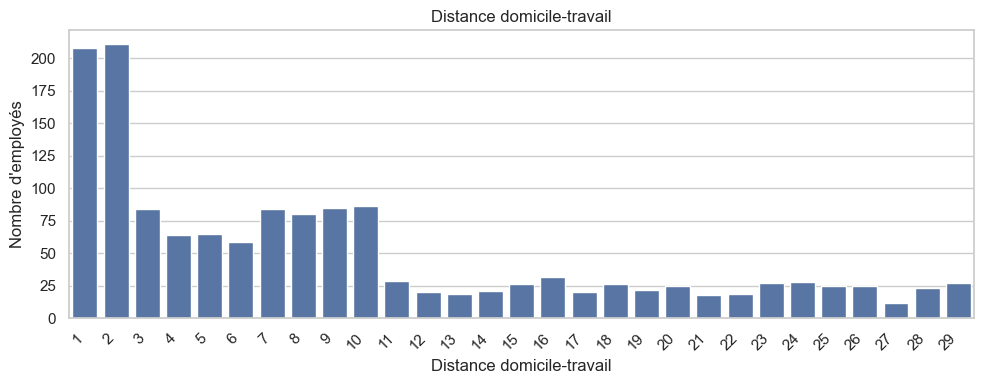

In [52]:
# Histogramme pour 'distance_domicile_travail'
plt.figure(figsize=(10, 4))
sns.countplot(
    data=df_employes,
    x='distance_domicile_travail',
    order=sorted(df_employes['distance_domicile_travail'].unique())  # trie les distances
)
plt.title("Distance domicile-travail")
plt.xlabel("Distance domicile-travail")
plt.ylabel("Nombre d'employés")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Variables professionnelles

#### Fonction & statut

In [53]:
##### departement

In [54]:
df_employes['departement'].value_counts()

departement
Consulting             961
Commercial             446
Ressources Humaines     63
Name: count, dtype: int64

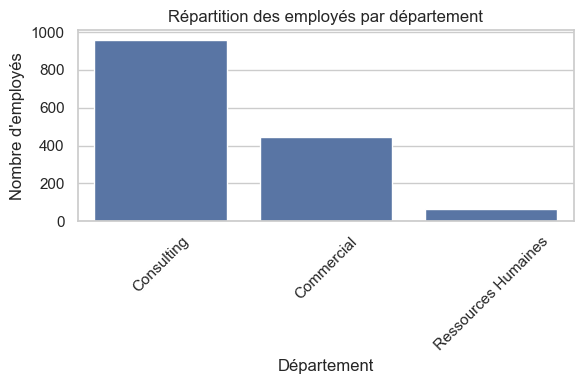

In [55]:
# Configuration de style
sns.set(style="whitegrid")

# Histogramme pour 'departement'
plt.figure(figsize=(6, 4))
sns.countplot(data=df_employes, x='departement', order=df_employes['departement'].value_counts().index)
plt.title("Répartition des employés par département")
plt.xlabel("Département")
plt.ylabel("Nombre d'employés")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La variable `departement` contient une faible cardinalité (3 modalités) représentant des catégories non ordinales.  
Un encodage one-hot est approprié ici car :
- Les modalités sont peu nombreuses,
- Il n’existe aucun ordre logique entre elles,
- Cela permet une bonne interprétabilité par les modèles.

L'encodage sera réalisé plus tard dans le pipeline à l’aide d’un `OneHotEncoder`.

#### poste

In [56]:
df_employes['poste'].value_counts()

poste
Cadre Commercial           326
Assistant de Direction     292
Consultant                 259
Tech Lead                  145
Manager                    131
Senior Manager             102
Représentant Commercial     83
Directeur Technique         80
Ressources Humaines         52
Name: count, dtype: int64

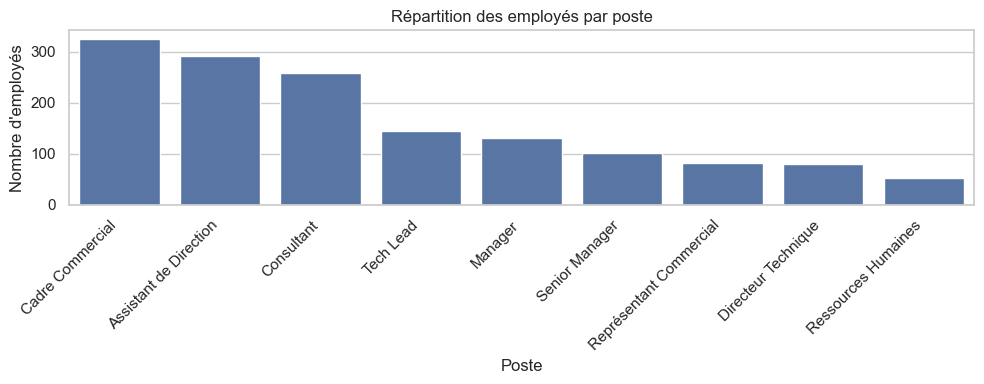

In [57]:
# Histogramme pour 'poste'
plt.figure(figsize=(10, 4))
sns.countplot(data=df_employes, x='poste', order=df_employes['poste'].value_counts().index)
plt.title("Répartition des employés par poste")
plt.xlabel("Poste")
plt.ylabel("Nombre d'employés")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

La variable `poste` comporte 9 modalités non ordinales.


In [58]:
##### niveau_hierarchique_poste

In [59]:
df_employes['niveau_hierarchique_poste'].value_counts()

niveau_hierarchique_poste
1    543
2    534
3    218
4    106
5     69
Name: count, dtype: int64

La variable `niveau_hierarchique_poste` est une variable ordinale (plus le niveau est élevé, plus la position hiérarchique est haute).  
Un `OrdinalEncoder` est donc parfaitement adapté car :
- Il préserve l’ordre naturel des modalités,
- Il fournit une information utile aux modèles linéaires ou d’arbres.

L'encodage sera effectué dans le pipeline à l’aide d’un `OrdinalEncoder`.


#### Expérience

In [60]:
##### nombre_experiences_precedentes

In [61]:
df_employes['nombre_experiences_precedentes'].value_counts()

nombre_experiences_precedentes
1    521
0    197
3    159
2    146
4    139
7     74
6     70
5     63
9     52
8     49
Name: count, dtype: int64

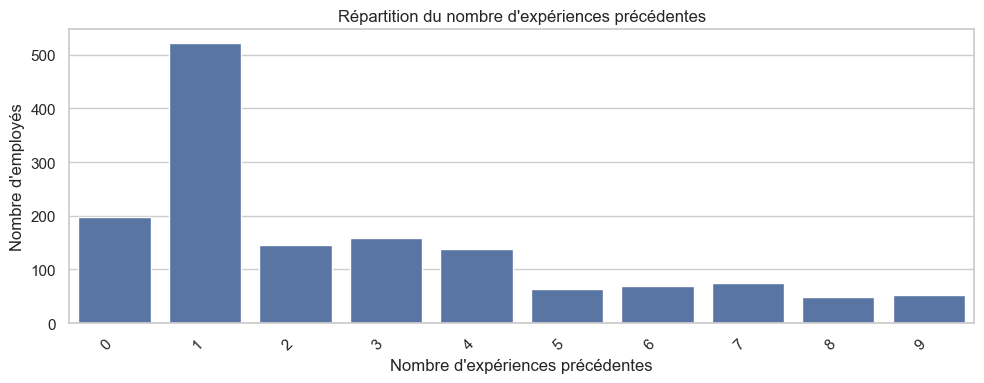

In [62]:
# Histogramme trié par valeur croissante de 'nombre_experiences_precedentes'
plt.figure(figsize=(10, 4))
sns.countplot(
    data=df_employes,
    x='nombre_experiences_precedentes',
    order=sorted(df_employes['nombre_experiences_precedentes'].unique())  # clé ici
)
plt.title("Répartition du nombre d'expériences précédentes")
plt.xlabel("Nombre d'expériences précédentes")
plt.ylabel("Nombre d'employés")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

La variable `nombre_experiences_precedentes` est une variable numérique discrète qui représente le nombre d'expériences professionnelles antérieures de chaque employé.  
Elle prend des valeurs comprises entre 0 et 9, avec une distribution légèrement décroissante.

Compte tenu de sa nature ordonnée, cette variable sera conservée telle quelle dans la modélisation et encodée par un **Ordinal Encoder**, afin de respecter la progression naturelle du nombre d’expériences.

In [63]:
##### annee_experience_totale

In [64]:
df_employes['annee_experience_totale'].describe()

count    1470.000000
mean       11.279592
std         7.780782
min         0.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        40.000000
Name: annee_experience_totale, dtype: float64

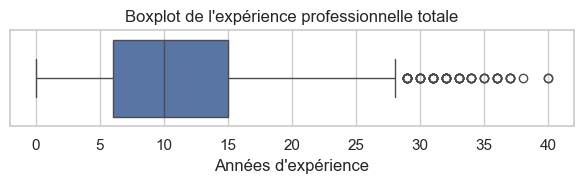

In [65]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['annee_experience_totale'])
plt.title("Boxplot de l'expérience professionnelle totale")
plt.xlabel("Années d'expérience")
plt.tight_layout()
plt.show()

La variable `annee_experience_totale` est une variable numérique continue représentant l'ancienneté professionnelle totale des employés (min=0, max=40).  
Sa distribution présente une dispersion importante avec une moyenne de 11,28 et un écart-type de 7,78.

In [66]:
##### annees_dans_l_entreprise

In [67]:
df_employes['annees_dans_l_entreprise'].describe()

count    1470.000000
mean        7.008163
std         6.126525
min         0.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        40.000000
Name: annees_dans_l_entreprise, dtype: float64

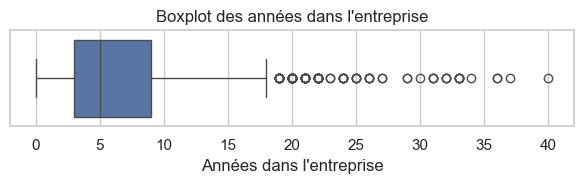

In [68]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['annees_dans_l_entreprise'])
plt.title("Boxplot des années dans l'entreprise")
plt.xlabel("Années dans l'entreprise")
plt.tight_layout()
plt.show()

In [69]:
##### annees_dans_le_poste_actuel

In [70]:
df_employes['annees_dans_le_poste_actuel'].describe()

count    1470.000000
mean        4.229252
std         3.623137
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        18.000000
Name: annees_dans_le_poste_actuel, dtype: float64

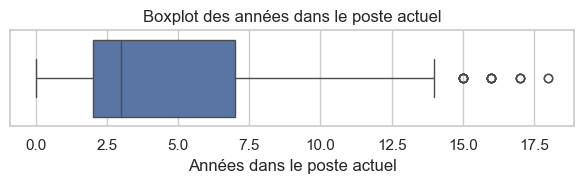

In [71]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['annees_dans_le_poste_actuel'])
plt.title("Boxplot des années dans le poste actuel")
plt.xlabel("Années dans le poste actuel")
plt.tight_layout()
plt.show()

In [72]:
##### annes_sous_responsable_actuel

In [73]:
df_employes['annes_sous_responsable_actuel'].describe()

count    1470.000000
mean        4.123129
std         3.568136
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        17.000000
Name: annes_sous_responsable_actuel, dtype: float64

In [74]:
df_employes['annes_sous_responsable_actuel'] = df_employes['annes_sous_responsable_actuel'].astype(int)

In [75]:
df_employes['annes_sous_responsable_actuel'].describe()

count    1470.000000
mean        4.123129
std         3.568136
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        17.000000
Name: annes_sous_responsable_actuel, dtype: float64

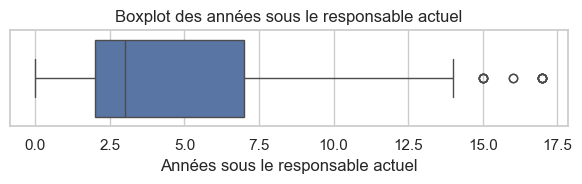

In [76]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['annes_sous_responsable_actuel'])
plt.title("Boxplot des années sous le responsable actuel")
plt.xlabel("Années sous le responsable actuel")
plt.tight_layout()
plt.show()

In [77]:
##### annees_depuis_la_derniere_promotion

In [78]:
df_employes['annees_depuis_la_derniere_promotion'].describe()

count    1470.000000
mean        2.187755
std         3.222430
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        15.000000
Name: annees_depuis_la_derniere_promotion, dtype: float64

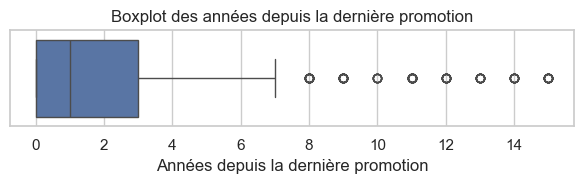

In [79]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['annees_depuis_la_derniere_promotion'])
plt.title("Boxplot des années depuis la dernière promotion")
plt.xlabel("Années depuis la dernière promotion")
plt.tight_layout()
plt.show()

Nous pouvons constater que 25% des employés auraient eu une promotion il y a moins d'un an. Difficile de dire à ce stade ce que cela signifie, nous en saurons peut-être plus lors de l'analyse bivariée.

Ces dernières variables représentent des durées exprimées en années. Afin de garantir une échelle cohérente pour les modèles de machine learning, une mise à l’échelle sera effectuée ultérieurement dans le pipeline de transformation. Cela permet notamment de limiter l’impact de ces variables lors du calcul des distances ou des coefficients dans les modèles linéaires.

#### Encadrement

In [80]:
##### nombre_employee_sous_responsabilite

In [81]:
df_employes['nombre_employee_sous_responsabilite'].describe()

count    1470.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: nombre_employee_sous_responsabilite, dtype: float64

On voit que cette colonne ne contient qu'une valeur, on va donc la supprimer

In [82]:
# Suppression de la colonne
df_employes.drop(columns='nombre_employee_sous_responsabilite', inplace=True)

### Engagement & formation

##### nombre_participation_pee

In [83]:
df_employes['nombre_participation_pee'].describe()

count    1470.000000
mean        0.793878
std         0.852077
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: nombre_participation_pee, dtype: float64

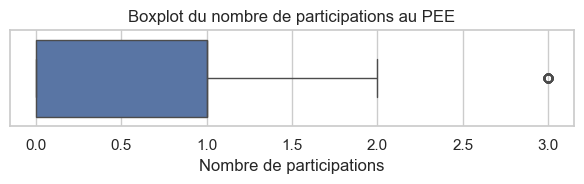

In [84]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['nombre_participation_pee'])
plt.title("Boxplot du nombre de participations au PEE")
plt.xlabel("Nombre de participations")
plt.tight_layout()
plt.show()

##### nb_formations_suivies

In [85]:
df_employes['nb_formations_suivies'].describe()

count    1470.000000
mean        2.799320
std         1.289271
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         6.000000
Name: nb_formations_suivies, dtype: float64

In [86]:
df_employes['nb_formations_suivies'].unique()

array([0, 3, 2, 5, 1, 4, 6])

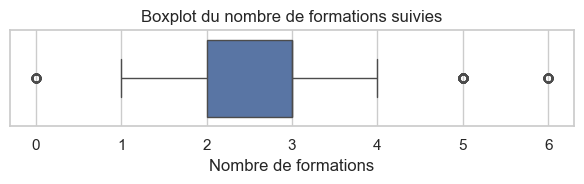

In [87]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['nb_formations_suivies'])
plt.title("Boxplot du nombre de formations suivies")
plt.xlabel("Nombre de formations")
plt.tight_layout()
plt.show()

##### heures_supplementaires

In [88]:
df_employes['heure_supplementaires'].value_counts()

heure_supplementaires
Non    1054
Oui     416
Name: count, dtype: int64

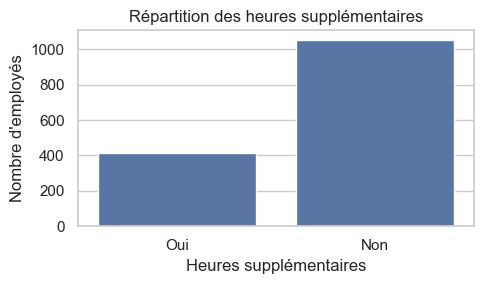

In [89]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_employes, x='heure_supplementaires')
plt.title("Répartition des heures supplémentaires")
plt.xlabel("Heures supplémentaires")
plt.ylabel("Nombre d'employés")
plt.tight_layout()
plt.show()

##### augmentation_salaire_precedente

In [90]:
df_employes['augementation_salaire_precedente'].value_counts()

augementation_salaire_precedente
11 %    210
13 %    209
14 %    201
12 %    198
15 %    101
18 %     89
17 %     82
16 %     78
19 %     76
22 %     56
20 %     55
21 %     48
23 %     28
24 %     21
25 %     18
Name: count, dtype: int64

In [91]:
# Nettoyage des caractères %
df_employes['augementation_salaire_precedente'] = df_employes['augementation_salaire_precedente'].str.replace("%", "", regex=False)

In [92]:
df_employes['augementation_salaire_precedente'].value_counts()

augementation_salaire_precedente
11     210
13     209
14     201
12     198
15     101
18      89
17      82
16      78
19      76
22      56
20      55
21      48
23      28
24      21
25      18
Name: count, dtype: int64

In [93]:
# On le convertir en float
df_employes['augementation_salaire_precedente'] = df_employes['augementation_salaire_precedente'].astype(float)

In [94]:
# Division par 100 car ce sont des proportions
df_employes['augementation_salaire_precedente'] = df_employes['augementation_salaire_precedente'] / 100

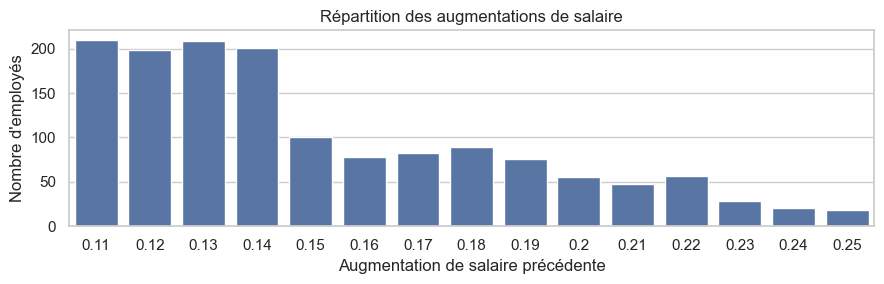

In [95]:
plt.figure(figsize=(9, 3))
sns.countplot(data=df_employes, x='augementation_salaire_precedente')
plt.title("Répartition des augmentations de salaire")
plt.xlabel("Augmentation de salaire précédente")
plt.ylabel("Nombre d'employés")
plt.tight_layout()
plt.show()

##### revenu_mensuel

In [96]:
df_employes['revenu_mensuel'].describe()

count     1470.000000
mean      6502.931293
std       4707.956783
min       1009.000000
25%       2911.000000
50%       4919.000000
75%       8379.000000
max      19999.000000
Name: revenu_mensuel, dtype: float64

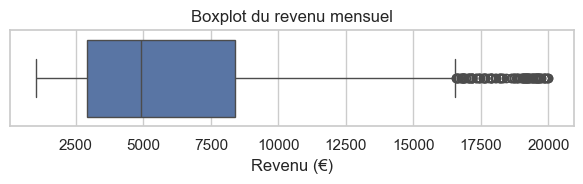

In [97]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_employes['revenu_mensuel'])
plt.title("Boxplot du revenu mensuel")
plt.xlabel("Revenu (€)")
plt.tight_layout()
plt.show()

##### nombre_heures_travailless

In [98]:
df_employes['nombre_heures_travailless'].describe()

count    1470.0
mean       80.0
std         0.0
min        80.0
25%        80.0
50%        80.0
75%        80.0
max        80.0
Name: nombre_heures_travailless, dtype: float64

On voit que tous les salariés travaillent 80 heures, ce qui doit être une erreur, et c'est en plus en dehors des heures légales. Si cette donnée était exacte, elle suffirait à elle seule à expliquer les départs et l'analyse pourrait s'arrêter là. On va supprimer la colonne

In [99]:
df_employes.drop(columns='nombre_heures_travailless', inplace=True)

### Évaluations & satisfaction

##### note_evaluation_precedente

In [100]:
df_employes['note_evaluation_precedente'].value_counts()

note_evaluation_precedente
3    868
2    375
4    144
1     83
Name: count, dtype: int64

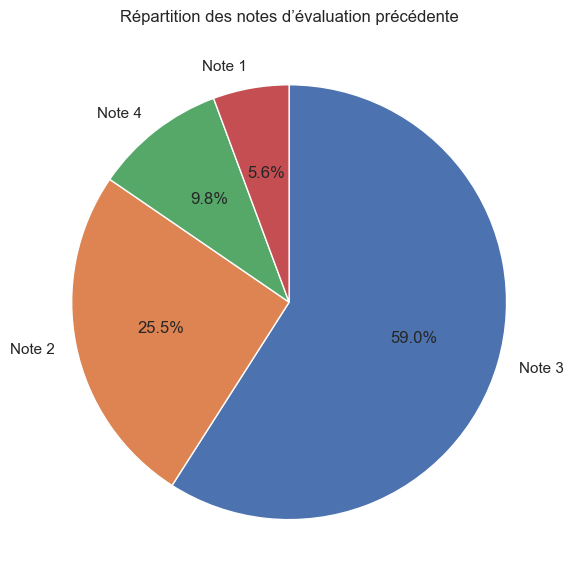

In [101]:
eval_prec = df_employes['note_evaluation_precedente'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    eval_prec,
    labels=[f"Note {i}" for i in eval_prec.index],
    autopct='%1.1f%%',      # Ajoute les pourcentages
    startangle=90,          # Commence à 12h
    counterclock=False,     # Sens horaire
    wedgeprops={"edgecolor": "white"}  # Meilleure séparation des parts
)
plt.title("Répartition des notes d’évaluation précédente")
plt.tight_layout()
plt.show()

##### note_evaluation_actuelle

In [102]:
df_employes['note_evaluation_actuelle'].value_counts()

note_evaluation_actuelle
3    1244
4     226
Name: count, dtype: int64

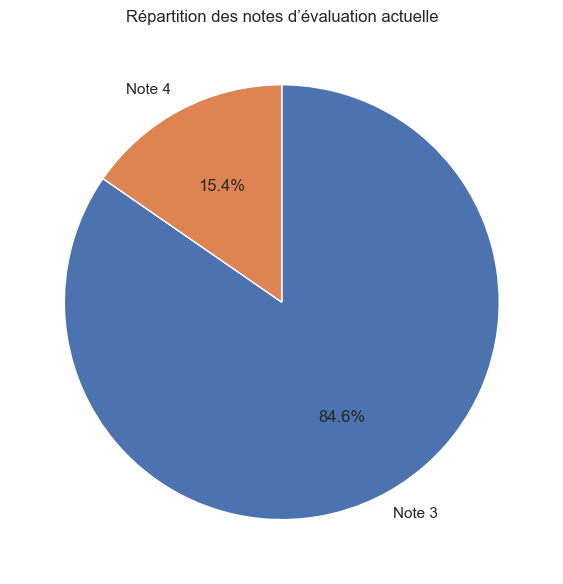

In [103]:
eval_actuelle = df_employes['note_evaluation_actuelle'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(
    eval_actuelle,
    labels=[f"Note {i}" for i in eval_actuelle.index],
    autopct='%1.1f%%',      # Ajoute les pourcentages
    startangle=90,          # Commence à 12h
    counterclock=False,     # Sens horaire
    wedgeprops={"edgecolor": "white"}  # Meilleure séparation des parts
)
plt.title("Répartition des notes d’évaluation actuelle")
plt.tight_layout()
plt.show()


##### satisfaction_employee_environnement

In [104]:
df_employes['satisfaction_employee_environnement'].value_counts()

satisfaction_employee_environnement
3    453
4    446
2    287
1    284
Name: count, dtype: int64

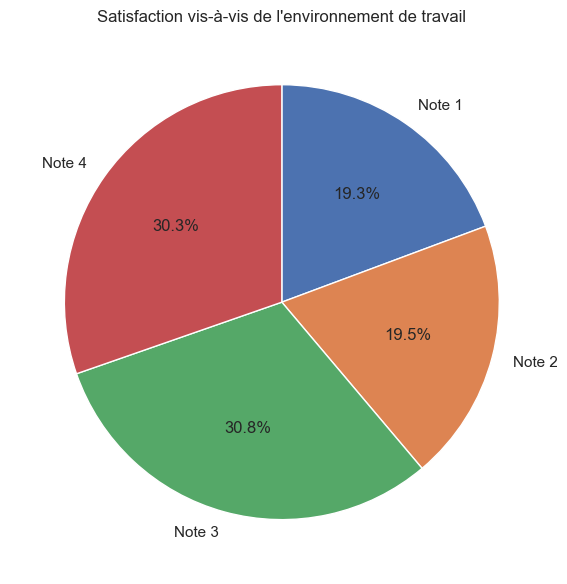

In [105]:
env_sat = df_employes['satisfaction_employee_environnement'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(
    env_sat,
    labels=[f"Note {i}" for i in env_sat.index],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Satisfaction vis-à-vis de l'environnement de travail")
plt.tight_layout()
plt.show()


##### satisfaction_employee_nature_travail

In [106]:
df_employes['satisfaction_employee_nature_travail'].value_counts()

satisfaction_employee_nature_travail
4    459
3    442
1    289
2    280
Name: count, dtype: int64

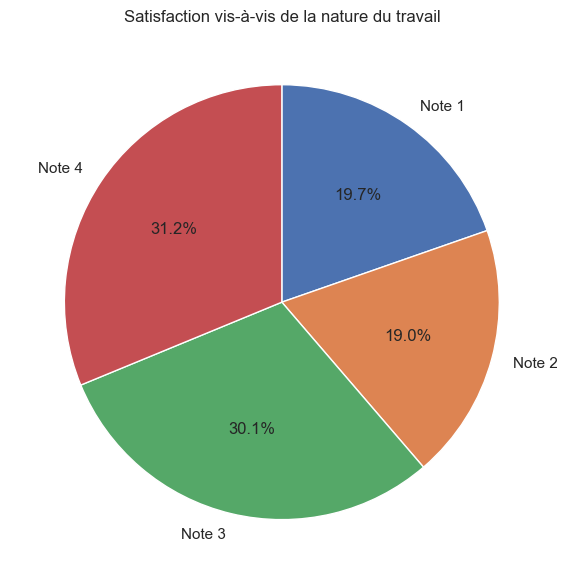

In [107]:
nat_trav_sat = df_employes['satisfaction_employee_nature_travail'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(
    nat_trav_sat,
    labels=[f"Note {i}" for i in nat_trav_sat.index],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Satisfaction vis-à-vis de la nature du travail")
plt.tight_layout()
plt.show()


##### satisfaction_employee_equipe

In [108]:
df_employes['satisfaction_employee_equipe'].value_counts()

satisfaction_employee_equipe
3    459
4    432
2    303
1    276
Name: count, dtype: int64

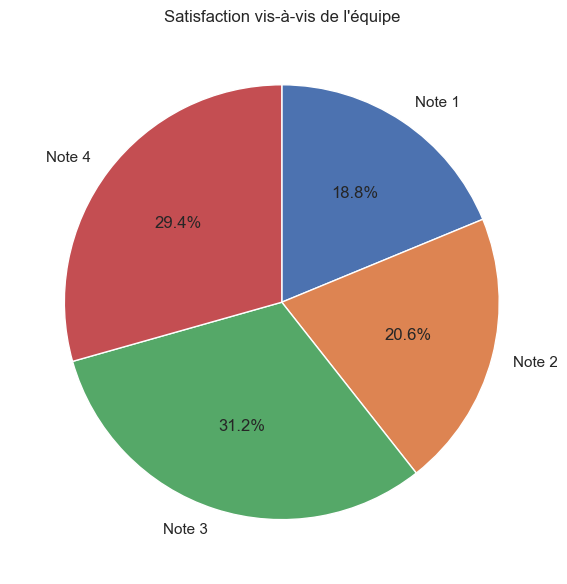

In [109]:
equipe_sat = df_employes['satisfaction_employee_equipe'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(
    equipe_sat,
    labels=[f"Note {i}" for i in equipe_sat.index],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Satisfaction vis-à-vis de l'équipe")
plt.tight_layout()
plt.show()

##### satisfaction_employee_equilibre_pro_perso

In [110]:
df_employes['satisfaction_employee_equilibre_pro_perso'].value_counts()

satisfaction_employee_equilibre_pro_perso
3    893
2    344
4    153
1     80
Name: count, dtype: int64

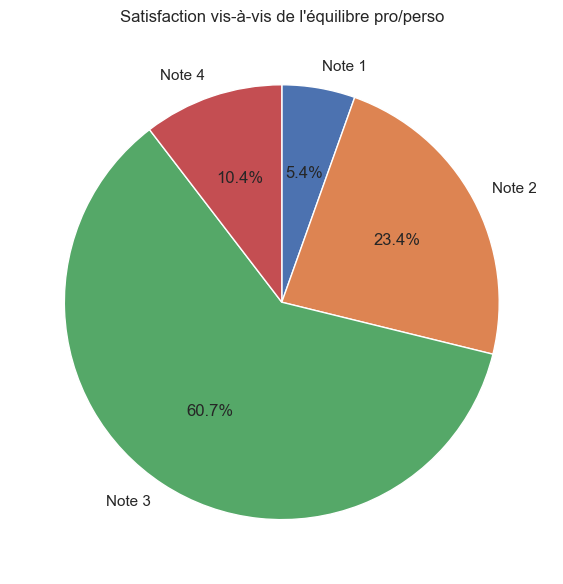

In [111]:
equilibre_sat = df_employes['satisfaction_employee_equilibre_pro_perso'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(
    equilibre_sat,
    labels=[f"Note {i}" for i in equilibre_sat.index],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Satisfaction vis-à-vis de l'équilibre pro/perso")
plt.tight_layout()
plt.show()


## Analyses bivariées et multivariée avec la cible

### Comparaison de la cible avec les facteurs sociodémographiques

##### Age

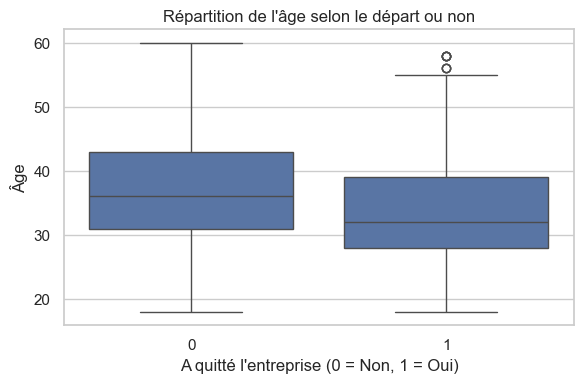

In [112]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='a_quitte_l_entreprise', y='age', data=df_employes)
plt.title("Répartition de l'âge selon le départ ou non")
plt.xlabel("A quitté l'entreprise (0 = Non, 1 = Oui)")
plt.ylabel("Âge")
plt.tight_layout()
plt.show()

Apparemment les personnes qui partent semblent globalement plus jeunes. On va croiser avec le statut marital.

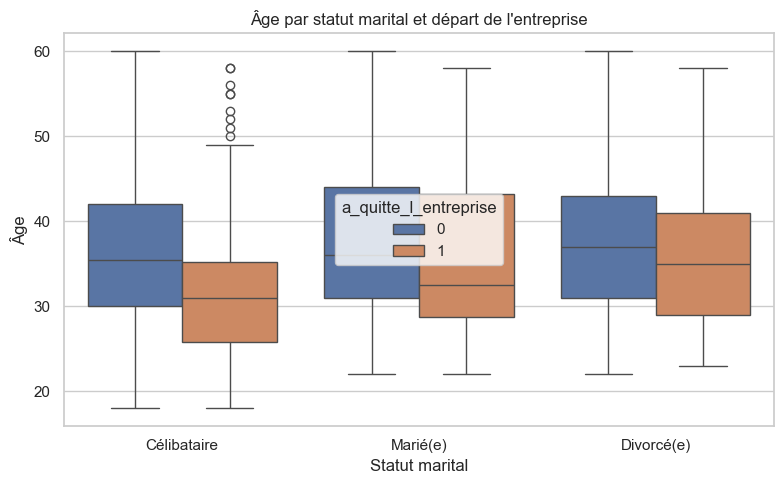

In [113]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_employes, x='statut_marital', y='age', hue='a_quitte_l_entreprise')
plt.title("Âge par statut marital et départ de l'entreprise")
plt.xlabel("Statut marital")
plt.ylabel("Âge")
plt.tight_layout()
plt.show()

On voit ici que le groupe des jeunes célibataires sont plus enclins à quitter l'entreprise. Les mariés et divorcés qui partent sont un peu plus jeune mais de façon beaucoup moins significative que le premier groupe.

On va effectuer une nouvelle comparaison, toujours avec l'âge, mais cette fois-ci avec le revenu mensuel

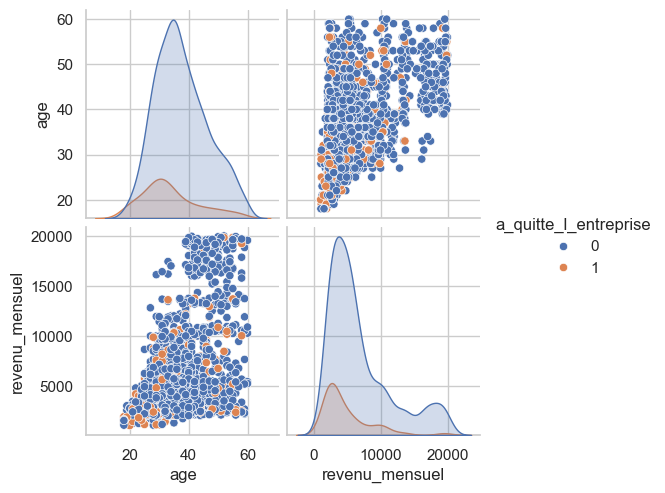

In [114]:
sns.pairplot(df_employes, vars=['age', 'revenu_mensuel'], hue='a_quitte_l_entreprise')


Ici on remarque que ce sont plutôt les bas revenus de moins de 30 ans qui partent.

Boxplot triple-catégorie
Croise 2 variables catégorielles (ex. genre + statut marital) avec une variable numérique (ex. âge) :

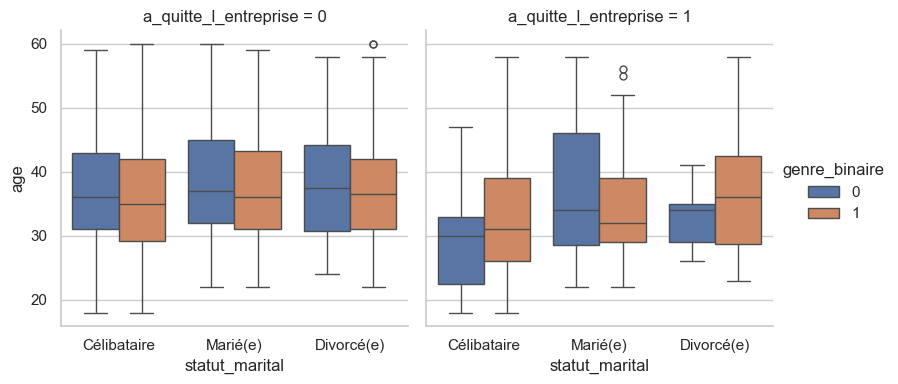

In [115]:
sns.catplot(
    data=df_employes,
    x='statut_marital',
    y='age',
    col='a_quitte_l_entreprise',
    hue='genre_binaire',
    kind='box',
    height=4,
    aspect=1
)


Sur ce graphique, on peut voir que :
- Les personnes entre 30 et 45 ans représentent le gros des troupes qui restent, quelque soit leur statut marital
- Les femmes de moins de 30 ans sont très représentées dans les départ

On va créer une feature sur les tranches d'âges

In [116]:
# Création de la variable catégorielle 'tranche_age'
def classer_age(age):
    if age < 35:
        return "Junior"
    elif age <= 45:
        return "Intermédiaire"
    else:
        return "Senior"

df_employes["tranche_age"] = df_employes["age"].apply(classer_age)

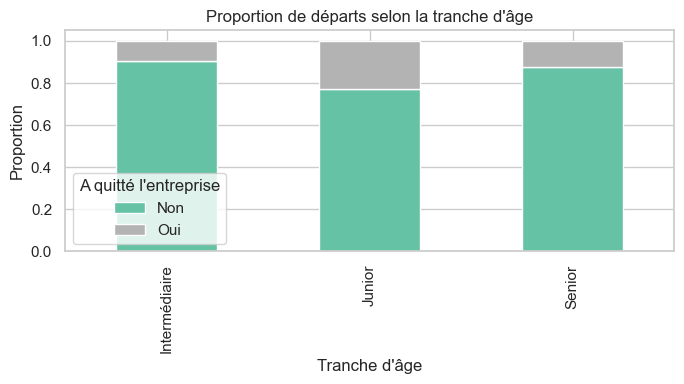

In [117]:
# Comparaison de la cible avec la tranche d'age
# Calcul des proportions de départs par tranche d'âge
proportions_age = (
    df_employes.groupby('tranche_age')['a_quitte_l_entreprise']
    .value_counts(normalize=True)
    .unstack()
)

# Affichage du barplot empilé
proportions_age.plot(
    kind='bar',
    stacked=True,
    figsize=(7, 4),
    colormap='Set2'
)

plt.title("Proportion de départs selon la tranche d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Proportion")
plt.legend(title="A quitté l'entreprise", labels=["Non", "Oui"])
plt.tight_layout()
plt.show()

### Méthodes utilisées
- Pour les croisements **quantitatif vs cible** :
  - `boxplot`, `violinplot`, `swarmplot`
  - Moyenne par groupe (`groupby("target").mean()`)


Pour les croisements **qualitatif vs cible** :
  - `countplot` avec `hue="target"`
  - Taux de démission par catégorie via `groupby() + normalize`

### Matrices de corrélation

#### Corrélations entre les variables numériques

Cette matrice de corrélation permet d’identifier les relations linéaires entre les variables quantitatives continues. Elle aide à repérer d’éventuelles redondances ou corrélations fortes qui pourraient nécessiter un retraitement ou une sélection ultérieure.

In [118]:
# Sélection des colonnes numériques continues
num_cols = [
    "age",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annees_depuis_la_derniere_promotion",
    "annes_sous_responsable_actuel",
    "augementation_salaire_precedente",
    "nombre_experiences_precedentes",
    "nombre_participation_pee",
    "nb_formations_suivies",
    "revenu_mensuel"
]

df_numeric = df_employes[num_cols]

In [119]:
corr_matrix = df_numeric.corr()
corr_matrix

,age,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,augementation_salaire_precedente,nombre_experiences_precedentes,nombre_participation_pee,nb_formations_suivies,revenu_mensuel
age,1.000000,0.680381,0.311309,0.212901,0.216513,0.202089,0.003634,0.299635,0.037510,-0.019621,0.497855
annee_experience_totale,0.680381,1.000000,0.628133,0.460365,0.404858,0.459188,-0.020608,0.237639,0.010136,-0.035662,0.772893
annees_dans_l_entreprise,0.311309,0.628133,1.000000,0.758754,0.618409,0.769212,-0.035991,-0.118421,0.015058,0.003569,0.514285
annees_dans_le_poste_actuel,0.212901,0.460365,0.758754,1.000000,0.548056,0.714365,-0.001520,-0.090754,0.050818,-0.005738,0.363818
annees_depuis_la_derniere_promotion,0.216513,0.404858,0.618409,0.548056,1.000000,0.510224,-0.022154,-0.036814,0.014352,-0.002067,0.344978
annes_sous_responsable_actuel,0.202089,0.459188,0.769212,0.714365,0.510224,1.000000,-0.011985,-0.110319,0.024698,-0.004096,0.344079
augementation_salaire_precedente,0.003634,-0.020608,-0.035991,-0.001520,-0.022154,-0.011985,1.000000,-0.010238,0.007528,-0.005221,-0.027269
nombre_experiences_precedentes,0.299635,0.237639,-0.118421,-0.090754,-0.036814,-0.110319,-0.010238,1.000000,0.030075,-0.066054,0.149515
nombre_participation_pee,0.037510,0.010136,0.015058,0.050818,0.014352,0.024698,0.007528,0.030075,1.000000,0.011274,0.005408
nb_formations_suivies,-0.019621,-0.035662,0.003569,-0.005738,-0.002067,-0.004096,-0.005221,-0.066054,0.011274,1.000000,-0.021736


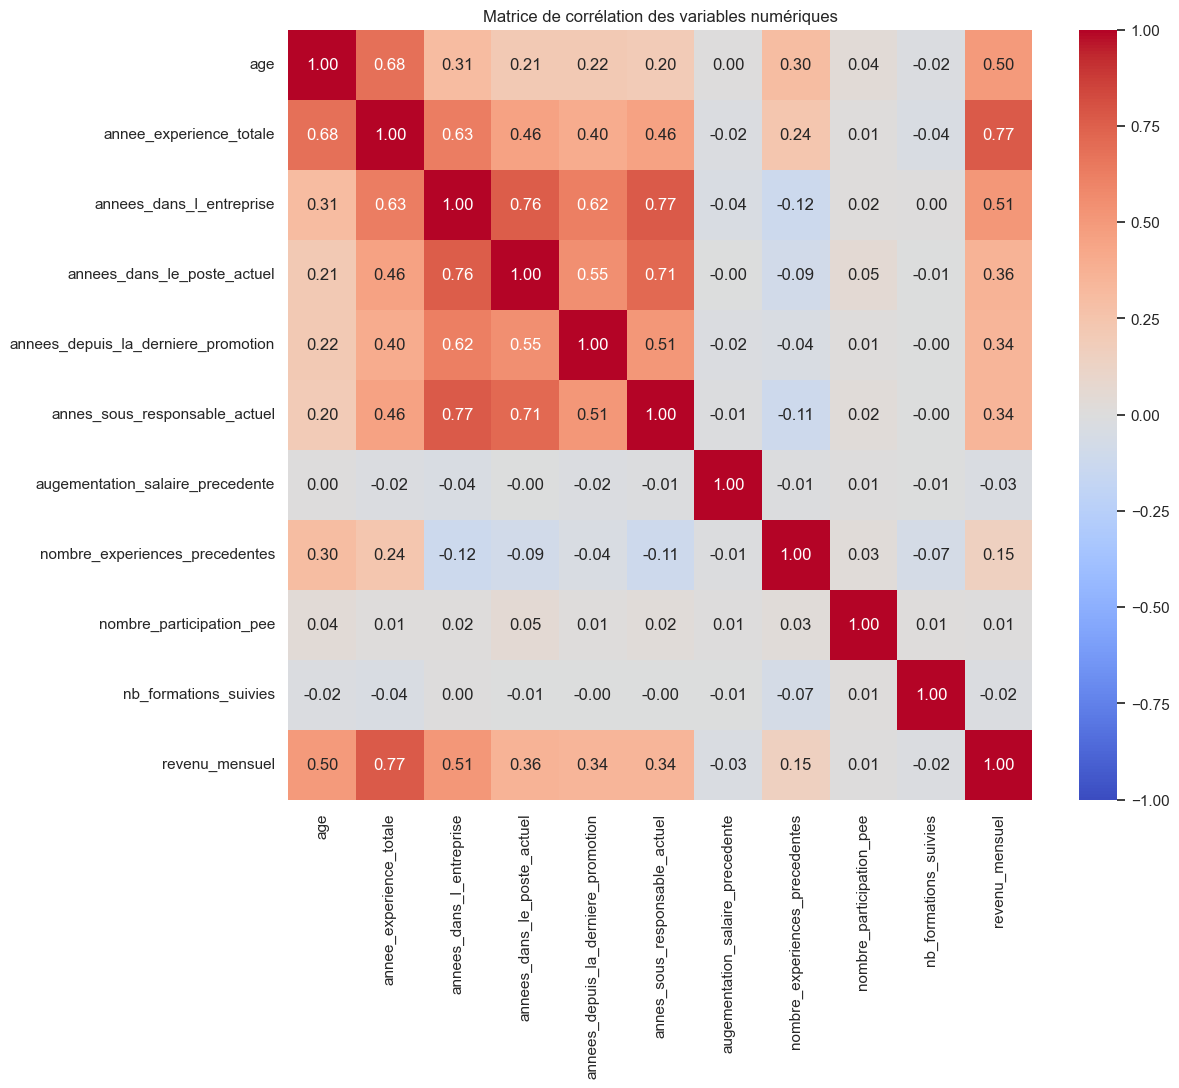

In [120]:
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Matrice de corrélation des variables numériques")
plt.show()

##### Analyse de la matrice de corrélation

**✅ Corrélations fortes (>0,70)**

Ces variables présentent une corrélation très élevée, ce qui indique qu’elles capturent en partie la même information :

annee_experience_totale et revenu_mensuel : 0,77
➔ Les années d’expérience totale expliquent largement le revenu.

annees_dans_l_entreprise et annees_dans_le_poste_actuel : 0,76
➔ Plus on reste longtemps dans l’entreprise, plus on reste longtemps au même poste.

annees_dans_l_entreprise et annes_sous_responsable_actuel : 0,77
➔ Ces deux durées évoluent ensemble.

annee_experience_totale et annees_dans_l_entreprise : 0,63
➔ L’expérience totale est en grande partie acquise dans l’entreprise.

annees_dans_le_poste_actuel et annes_sous_responsable_actuel : 0,71
➔ Ancienneté au poste et ancienneté sous le même responsable sont très liées.

Ces corrélations impliquent un risque de multicolinéarité qu’il faudra surveiller lors de la modélisation.

**⚠️ Corrélations moyennes (0,30–0,60)**

Ces variables sont modérément corrélées entre elles et/ou avec le revenu :

age et revenu_mensuel : 0,50

annees_dans_l_entreprise et revenu_mensuel : 0,51

annees_dans_le_poste_actuel et revenu_mensuel : 0,36

annees_depuis_la_derniere_promotion et revenu_mensuel : 0,34

annes_sous_responsable_actuel et revenu_mensuel : 0,34

Ces relations montrent que l’ancienneté sous différentes formes contribue au revenu, sans pour autant tout expliquer.

**🔹 Corrélations faibles (<0,30)**

Ces variables sont peu corrélées et apportent potentiellement une information complémentaire :

nombre_experiences_precedentes : corrélation faible avec revenu_mensuel (0,15) et corrélation négative avec annees_dans_l_entreprise (–0,12).

nombre_participation_pee : corrélations négligeables avec toutes les variables.

nb_formations_suivies : corrélations quasi nulles.

augementation_salaire_precedente : corrélations faibles voire nulles avec toutes les autres variables.

Ces variables pourraient enrichir l’explication si elles capturent des effets spécifiques.

#### Corrélations des valeurs numériques avec la cible

In [121]:
# Calculer les corrélations avec la cible
df_corr_numeric_cible = df_employes[[
    "age",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annees_depuis_la_derniere_promotion",
    "annes_sous_responsable_actuel",
    "augementation_salaire_precedente",
    "nombre_experiences_precedentes",
    "nombre_participation_pee",
    "nb_formations_suivies",
    "revenu_mensuel",
    "a_quitte_l_entreprise"
]]

cor_target = df_corr_numeric_cible.corr()['a_quitte_l_entreprise'].sort_values(ascending=False)

print(cor_target)

a_quitte_l_entreprise                  1.000000
nombre_experiences_precedentes         0.043494
augementation_salaire_precedente      -0.013478
annees_depuis_la_derniere_promotion   -0.033019
nb_formations_suivies                 -0.059478
annees_dans_l_entreprise              -0.134392
nombre_participation_pee              -0.137145
annes_sous_responsable_actuel         -0.156199
age                                   -0.159205
revenu_mensuel                        -0.159840
annees_dans_le_poste_actuel           -0.160545
annee_experience_totale               -0.171063
Name: a_quitte_l_entreprise, dtype: float64


C:\Users\Fab\AppData\Local\Temp\ipykernel_18984\319316314.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


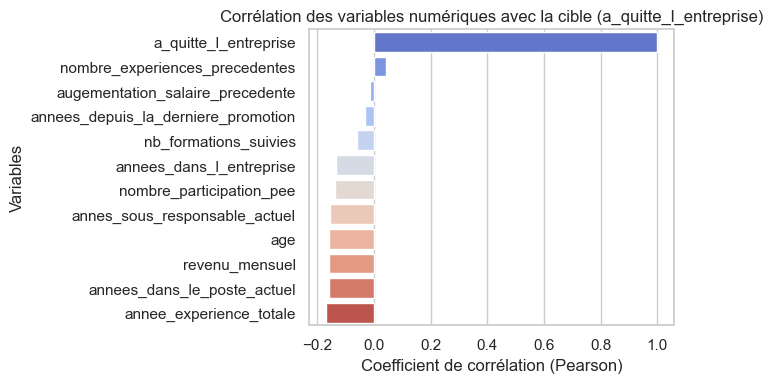

In [122]:
# Barplot des corrélations avec la cible
plt.figure(figsize=(7, 4))
sns.barplot(
    x=cor_target.values,
    y=cor_target.index,
    palette="coolwarm"
)
plt.title("Corrélation des variables numériques avec la cible (a_quitte_l_entreprise)")
plt.xlabel("Coefficient de corrélation (Pearson)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()


##### Analyse des corrélations avec la cible (*a_quitte_l_entreprise*)

Le graphique montre les coefficients de corrélation de Pearson entre chaque variable numérique et la variable cible **a_quitte_l_entreprise**.

✅ **Corrélations faibles à très faibles :**
- Aucune variable n’a une corrélation forte avec la cible.
- La majorité des coefficients sont compris entre –0,2 et +0,1.

✅ **Corrélations légèrement négatives :**
- **annee_experience_totale**, **annees_dans_le_poste_actuel**, **revenu_mensuel** et **age** ont une corrélation négative modérée (environ –0,1 à –0,2).
  - Cela suggère qu’une ancienneté et un revenu plus élevés sont associés à un risque un peu plus faible de départ.

✅ **Corrélations proches de zéro :**
- **nb_formations_suivies**, **nombre_participation_pee**, **augmentation_salaire_precedente** et **années depuis la dernière promotion** montrent des corrélations quasi nulles.
  - Ces variables n’ont pas de lien linéaire significatif avec la cible.

✅ **Corrélation légèrement positive :**
- **nombre_experiences_precedentes** est la seule variable avec une corrélation légèrement positive.
  - Les employés ayant plus d’expériences passées partent un peu plus souvent, mais l’effet reste faible.

**Synthèse :**
- Les variables numériques seules expliquent peu la variance de la cible.
- Il sera essentiel d’explorer :
  - Des variables catégorielles.
  - Des interactions entre variables.
  - Des modèles non linéaires.


#### Corrélations entre les valeurs d'évaluation

In [123]:
eval_cols = [
    'note_evaluation_precedente',
    'note_evaluation_actuelle',
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso'
]

df_eval = df_employes[eval_cols]

In [124]:
corr_matrix_eval = df_eval.corr()
corr_matrix_eval

,note_evaluation_precedente,note_evaluation_actuelle,satisfaction_employee_environnement,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso
note_evaluation_precedente,1.000000,-0.029071,-0.008278,-0.021476,0.034297,-0.014617
note_evaluation_actuelle,-0.029071,1.000000,-0.029548,0.002297,-0.031351,0.002572
satisfaction_employee_environnement,-0.008278,-0.029548,1.000000,-0.006784,0.007665,0.027627
satisfaction_employee_nature_travail,-0.021476,0.002297,-0.006784,1.000000,-0.012454,-0.019459
satisfaction_employee_equipe,0.034297,-0.031351,0.007665,-0.012454,1.000000,0.019604
satisfaction_employee_equilibre_pro_perso,-0.014617,0.002572,0.027627,-0.019459,0.019604,1.000000


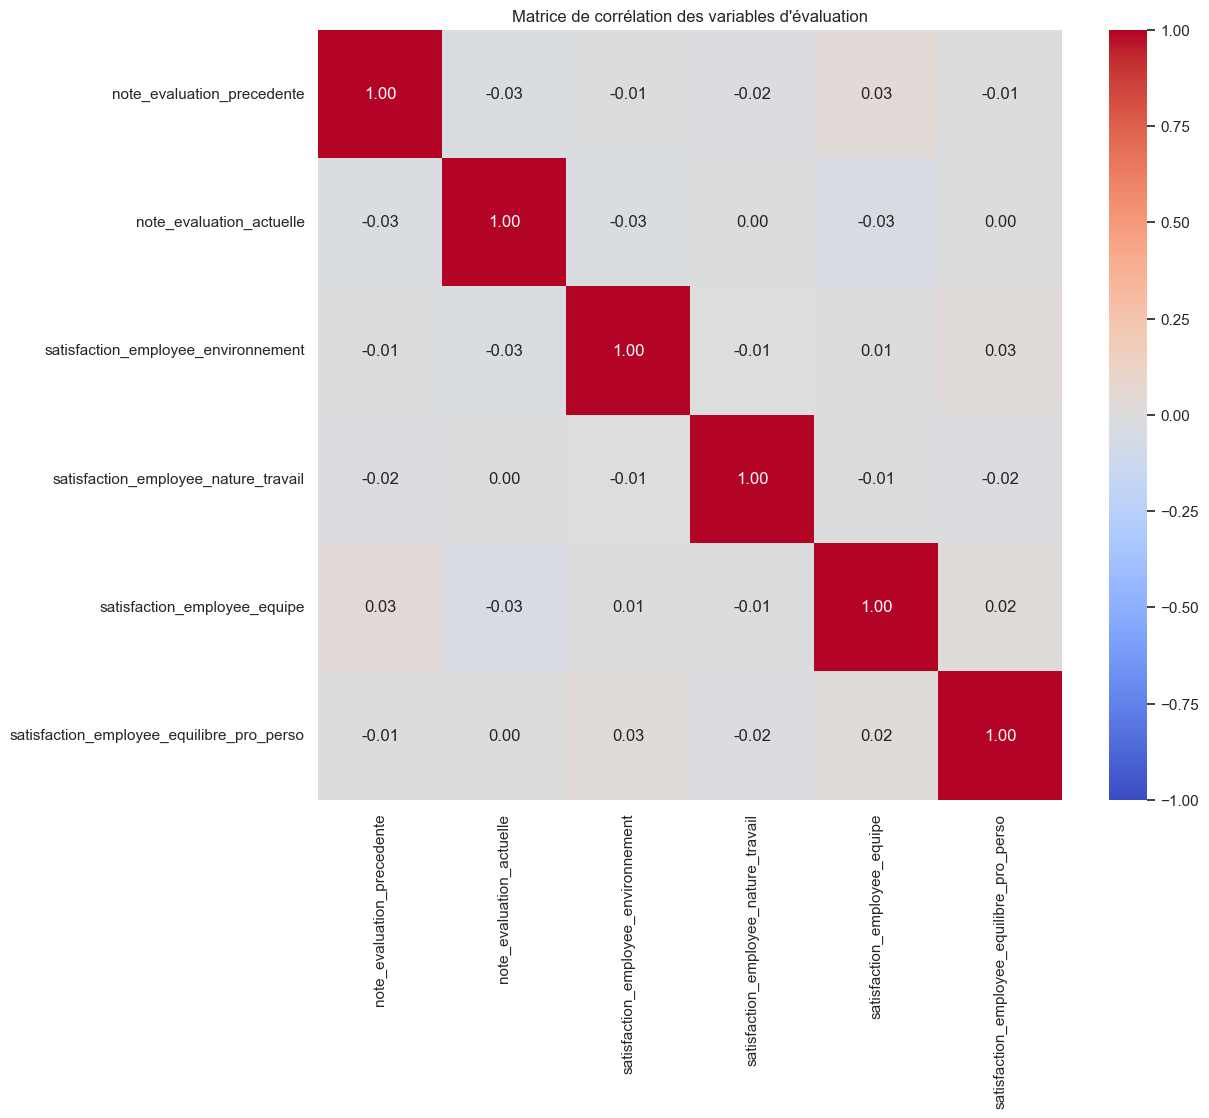

In [125]:
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix_eval,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Matrice de corrélation des variables d'évaluation")
plt.show()

#### Corrélations valeurs d'évaluation avec cible

In [126]:
df_corr_eval_cible = df_employes[[
    'note_evaluation_precedente',
    'note_evaluation_actuelle',
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
    'a_quitte_l_entreprise'
]]

cor__eval_target = df_corr_eval_cible.corr()['a_quitte_l_entreprise'].sort_values(ascending=False)

print(cor__eval_target)

a_quitte_l_entreprise                        1.000000
note_evaluation_actuelle                     0.002889
satisfaction_employee_equipe                -0.045872
satisfaction_employee_equilibre_pro_perso   -0.063939
satisfaction_employee_environnement         -0.103369
satisfaction_employee_nature_travail        -0.103481
note_evaluation_precedente                  -0.130016
Name: a_quitte_l_entreprise, dtype: float64


C:\Users\Fab\AppData\Local\Temp\ipykernel_18984\2571250505.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


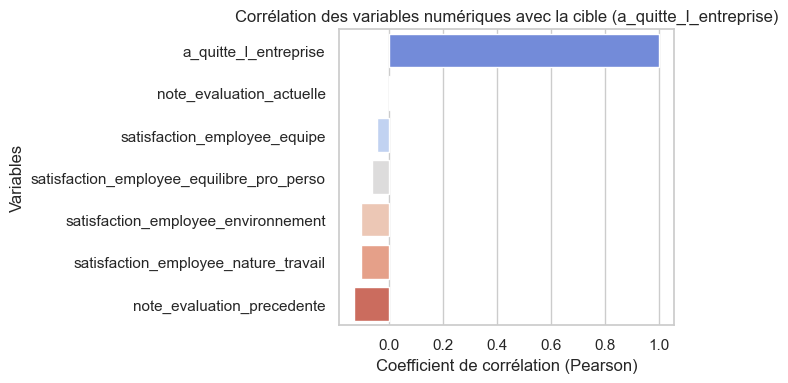

In [127]:
# Barplot des corrélations des évaluations avec la cible
plt.figure(figsize=(7, 4))
sns.barplot(
    x=cor__eval_target.values,
    y=cor__eval_target.index,
    palette="coolwarm"
)
plt.title("Corrélation des variables numériques avec la cible (a_quitte_l_entreprise)")
plt.xlabel("Coefficient de corrélation (Pearson)")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

## Feature engineering

### Ratio de stagnation
Créée pour refléter la corrélation forte entre l’ancienneté dans le poste et sous le même responsable, suggérant un effet de stagnation observé dans les corrélations.

In [128]:
df_employes["ratio_stagnation"] = (
    df_employes["annees_dans_le_poste_actuel"] /
    (df_employes["annees_dans_l_entreprise"] + 1)
)

### Ratio sous le même manager
Pour capturer la durée passée sous le même manager, identifiée comme potentiellement liée à la fidélité (corrélation forte).

In [129]:
df_employes["ratio_sous_responsable"] = (
    df_employes["annes_sous_responsable_actuel"] /
    (df_employes["annees_dans_l_entreprise"] + 1)
)

### Interaction âge x revenu
Créée pour tester l’interaction entre l’âge et le revenu, tous deux montrant des corrélations négatives modérées avec la cible.

In [130]:
df_employes["age_revenu"] = (
    df_employes["age"] * df_employes["revenu_mensuel"]
)

### Satisfaction moyenne

In [131]:
df_employes["satisfaction_moyenne"] = (
    df_employes["satisfaction_employee_environnement"] +
    df_employes["satisfaction_employee_equilibre_pro_perso"] +
    df_employes["satisfaction_employee_equipe"] +
    df_employes["satisfaction_employee_nature_travail"]
) / 4

In [132]:
df_employes["satisfaction_moyenne"].describe()

count    1470.000000
mean        2.730952
std         0.505815
min         1.000000
25%         2.500000
50%         2.750000
75%         3.000000
max         4.000000
Name: satisfaction_moyenne, dtype: float64

## Nouvelles features créées après la 2ème itération

### Interaction satisfaction moyenne × ancienneté
Logique métier :
Un employé ancien ET insatisfait est un profil de risque plus élevé qu’un employé junior insatisfait.

In [133]:
df_employes["interaction_satisfaction_anciennete"] = df_employes["satisfaction_moyenne"] * df_employes["annees_dans_l_entreprise"]

### Taux de formation
Logique métier :
Un employé peu formé par rapport à son ancienneté peut se sentir bloqué.

In [134]:
df_employes["taux_de_formation"] = df_employes["nb_formations_suivies"] / (df_employes["annees_dans_l_entreprise"] + 1)

### Interaction distance domicile × heures supplémentaires
Logique métier :
Un employé qui habite loin ET fait beaucoup d’heures supplémentaires peut avoir une charge plus lourde.

In [135]:
# Création du binaire heures supp
df_employes["heures_supplementaires_binaire"] = df_employes["heure_supplementaires"].map({"Oui":1, "Non":0})

# Création de l'interaction
df_employes["interaction_distance_heures_sup"] = (
    df_employes["heures_supplementaires_binaire"] * df_employes["distance_domicile_travail"]
)

In [136]:
# Suppression de la colonne heure_supplementaires avant transformation en binaire
df_employes.drop(columns='heure_supplementaires', inplace=True)

### Ratio ancienneté poste / ancienneté entreprise
Logique métier :
Un employé longtemps au même poste peut se sentir bloqué.

In [137]:
# Liste des nouvelles variables
new_features = [
    "interaction_satisfaction_anciennete",
    "taux_de_formation",
    "interaction_distance_heures_sup"
]

# Afficher les corrélations avec la cible
correlations_new = df_employes[new_features + ["a_quitte_l_entreprise"]].corr()

# Extraire uniquement la colonne cible
correlations_with_target = correlations_new["a_quitte_l_entreprise"].sort_values(key=abs, ascending=False)

print("=== Corrélations avec la cible ===")
print(correlations_with_target)

=== Corrélations avec la cible ===
a_quitte_l_entreprise                  1.000000
interaction_distance_heures_sup        0.236476
interaction_satisfaction_anciennete   -0.145519
taux_de_formation                      0.132908
Name: a_quitte_l_entreprise, dtype: float64


### Delta evaluation

In [138]:
# Liste de TOUTES les features créées (anciennes + nouvelles)
all_created_features = [
    "ratio_stagnation",
    "ratio_sous_responsable",
    "age_revenu",
    "satisfaction_moyenne",
    "interaction_satisfaction_anciennete",
    "taux_de_formation",
    "heures_supplementaires_binaire",
    "interaction_distance_heures_sup",
]

# Important : on ne peut calculer corr() que sur des variables numériques
# Donc il faut convertir les catégorielles en numériques si tu souhaites les inclure

# Pour simplifier, on peut les exclure du calcul de corrélation directe

# Liste filtrée des variables numériques
numeric_created_features = [
    "ratio_stagnation",
    "ratio_sous_responsable",
    "age_revenu",
    "satisfaction_moyenne",
    "interaction_satisfaction_anciennete",
    "taux_de_formation",
    "heures_supplementaires_binaire",
    "interaction_distance_heures_sup"
]

# Calcul des corrélations
corrs_all = df_employes[numeric_created_features + ["a_quitte_l_entreprise"]].corr()

# Extraire la colonne cible et trier
corrs_with_target = corrs_all["a_quitte_l_entreprise"].sort_values(key=abs, ascending=False)

# Afficher
print("=== Corrélations avec la cible (features créées) ===")
print(corrs_with_target)

=== Corrélations avec la cible (features créées) ===
a_quitte_l_entreprise                  1.000000
heures_supplementaires_binaire         0.246118
interaction_distance_heures_sup        0.236476
satisfaction_moyenne                  -0.159092
ratio_stagnation                      -0.157625
ratio_sous_responsable                -0.153259
age_revenu                            -0.152961
interaction_satisfaction_anciennete   -0.145519
taux_de_formation                      0.132908
Name: a_quitte_l_entreprise, dtype: float64


### Surmenage transport

In [139]:
# Encodage manuel de la fréquence de déplacement
frequence_mapping = {
    "Aucun": 0,
    "Occasionnel": 1,
    "Frequent": 2
}
df_employes["frequence_deplacement_num"] = df_employes["frequence_deplacement"].map(frequence_mapping)

# Création de la feature surmenage_transports
df_employes["surmenage_transports"] = (
    df_employes["heures_supplementaires_binaire"]
    * df_employes["distance_domicile_travail"]
    * df_employes["frequence_deplacement_num"]
)

In [140]:
# On supprime frequence_deplacement brute après l'encodage

In [141]:
df_employes.drop(columns=['frequence_deplacement'], inplace=True)

In [142]:
# Liste des variables créées
variables_creees = [
    "ratio_stagnation",
    "ratio_sous_responsable",
    "age_revenu",
    "satisfaction_moyenne",
    "interaction_satisfaction_anciennete",
    "heures_supplementaires_binaire",
    "interaction_distance_heures_sup",
    "surmenage_transports"
]

# Corrélation avec la cible
corr_cible = df_employes[variables_creees + ["a_quitte_l_entreprise"]].corr()
print("=== Corrélations avec la cible ===")
print(corr_cible["a_quitte_l_entreprise"].sort_values(ascending=False))

=== Corrélations avec la cible ===
a_quitte_l_entreprise                  1.000000
heures_supplementaires_binaire         0.246118
surmenage_transports                   0.236909
interaction_distance_heures_sup        0.236476
interaction_satisfaction_anciennete   -0.145519
age_revenu                            -0.152961
ratio_sous_responsable                -0.153259
ratio_stagnation                      -0.157625
satisfaction_moyenne                  -0.159092
Name: a_quitte_l_entreprise, dtype: float64


C:\Users\Fab\AppData\Local\Temp\ipykernel_18984\274100487.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


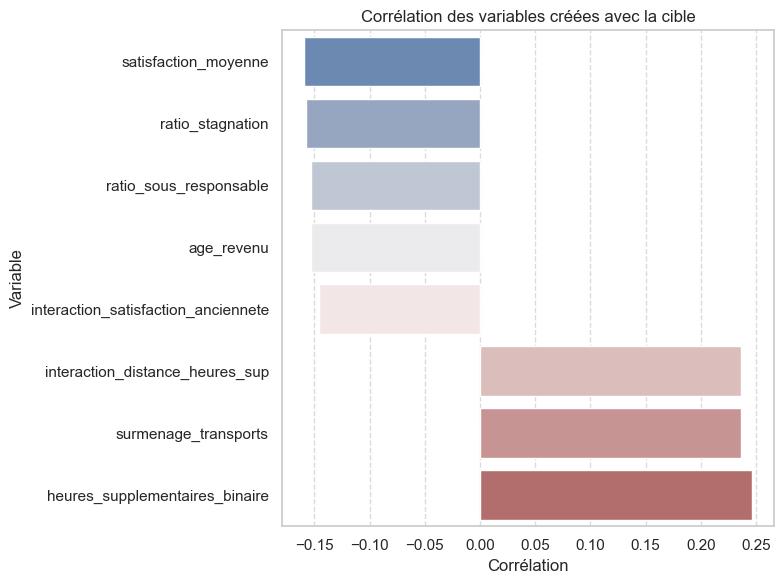

In [143]:
# Tri des corrélations avec la cible décroissant
correlations = corr_cible["a_quitte_l_entreprise"].drop("a_quitte_l_entreprise").sort_values(ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(
    x=correlations.values,
    y=correlations.index,
    palette="vlag"
)

plt.title("Corrélation des variables créées avec la cible")
plt.xlabel("Corrélation")
plt.ylabel("Variable")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


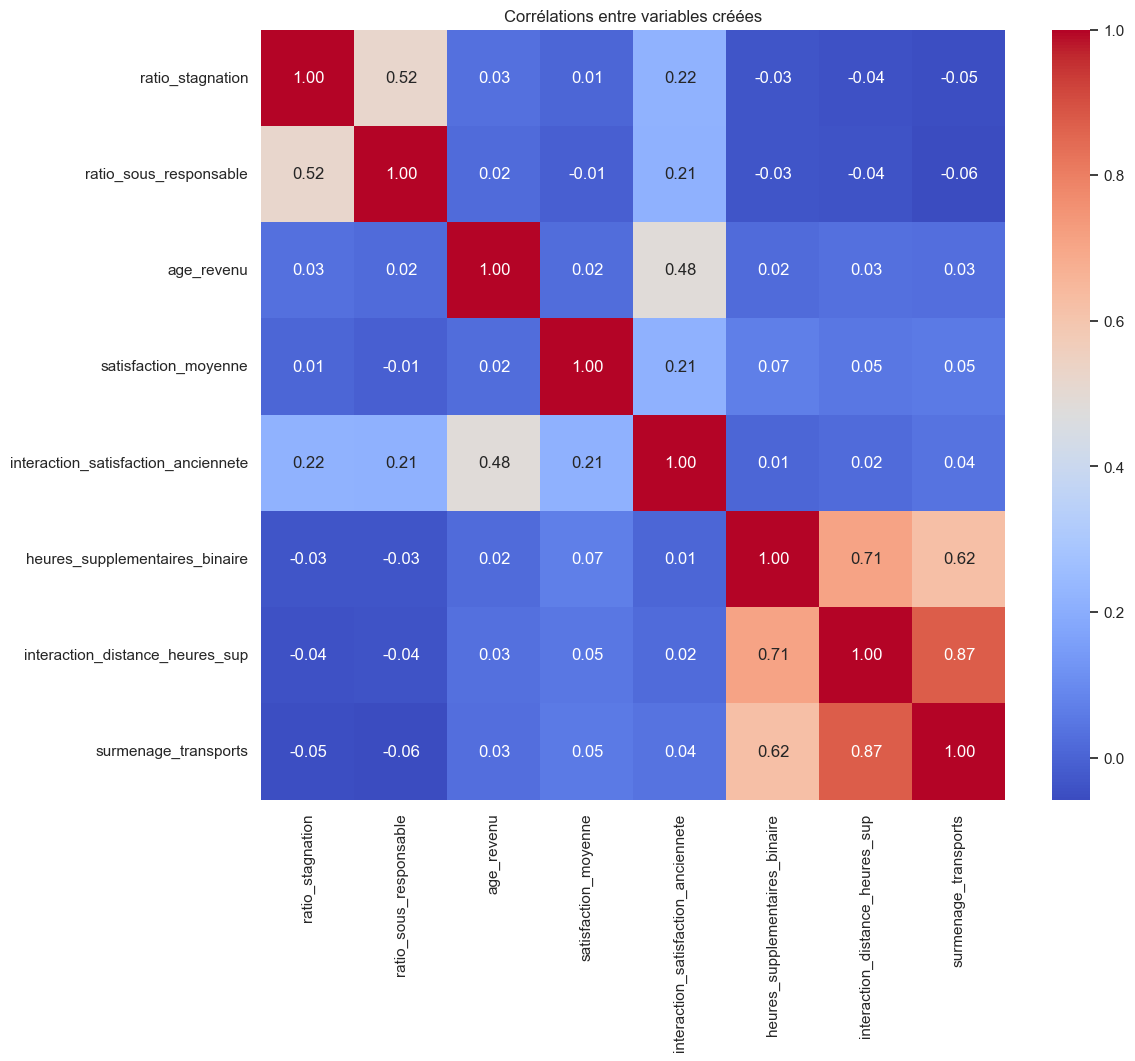

In [144]:
# Matrice de corrélation
corr_matrix = df_employes[variables_creees].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélations entre variables créées")
plt.show()

## Export en csv pour pipeline

In [145]:
# Export vers cvs pour le pipeline
df_employes.to_csv("data/employes_net_refacto.csv", index=False)

In [146]:
df_employes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        1470 non-null   int64  
 1   revenu_mensuel                             1470 non-null   int64  
 2   statut_marital                             1470 non-null   object 
 3   departement                                1470 non-null   object 
 4   poste                                      1470 non-null   object 
 5   nombre_experiences_precedentes             1470 non-null   int64  
 6   annee_experience_totale                    1470 non-null   int64  
 7   annees_dans_l_entreprise                   1470 non-null   int64  
 8   annees_dans_le_poste_actuel                1470 non-null   int64  
 9   a_quitte_l_entreprise                      1470 non-null   int64  
 10  nombre_participation_pee

In [147]:
df_employes.head()

,age,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,domaine_etude,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,augementation_salaire_precedente,genre_binaire,tranche_age,ratio_stagnation,ratio_sous_responsable,age_revenu,satisfaction_moyenne,interaction_satisfaction_anciennete,taux_de_formation,heures_supplementaires_binaire,interaction_distance_heures_sup,frequence_deplacement_num,surmenage_transports
0,41,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,1,0,0,1,2,Infra & Cloud,0,5,2,3,2,4,1,1,3,0.11,0,Intermédiaire,0.571429,0.714286,245713,2.00,12.0,0.000000,1,1,1,1
1,49,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,0,1,3,8,1,Infra & Cloud,1,7,3,2,2,2,4,3,4,0.23,1,Senior,0.636364,0.636364,251370,3.00,30.0,0.272727,0,0,2,0
2,37,2090,Célibataire,Consulting,Consultant,6,7,0,0,1,0,3,2,2,Autre,0,0,4,2,1,3,2,3,3,0.15,1,Intermédiaire,0.000000,0.000000,77330,3.00,0.0,3.000000,1,2,1,2
3,33,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,0,0,3,3,4,Infra & Cloud,3,0,4,3,1,3,3,3,3,0.11,0,Junior,0.777778,0.000000,95997,3.25,26.0,0.333333,1,3,2,6
4,27,3468,Marié(e),Consulting,Consultant,9,6,2,2,0,1,3,2,1,Transformation Digitale,2,2,1,3,1,2,4,3,3,0.12,1,Junior,0.666667,0.666667,93636,2.50,5.0,1.000000,0,0,1,0
